

# Bitcoin Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bitcoin exchanges in terms of average daily volume traded—Bitstamp (https://www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Core libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Libraries for Deep Learning Models

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


2022-09-16 08:15:21.223937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 08:15:21.224007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<a id='1.2'></a>
## 2.2. Loading the Data

#### <font color='red'>Note : Due to limit in the github for the data size, a sample of the data has been loaded in the jupyter notebook repository of this book. However, all the subsequent results in this jupyter notebook is with actual data (~150MB) under https://www.kaggle.com/mlfinancebook/bitstamp-bicoin-minutes-data. You should load the full data in case you want to reproduce the results. </font> 

In [2]:
# Load dataset
dataset = pd.read_csv('BitstampData_sample.csv')


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [4]:
# Shape

dataset.shape

(499999, 8)

In [5]:
# Peek at data

set_option('display.width', 100)
dataset.tail(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
499997,1355317740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499998,1355317800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Describe data

set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,5.000e+05,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000
mean,1.340e+09,9.822,9.825,9.818,9.821,21.022,206.749,9.822
std,8.660e+06,2.666,2.667,2.665,2.666,55.478,547.135,2.666
min,1.325e+09,3.800,3.800,3.800,3.800,0.000,0.000,3.800
25%,1.333e+09,7.200,7.200,7.200,7.200,2.170,21.020,7.200
50%,1.340e+09,10.800,10.800,10.790,10.790,7.340,67.920,10.793
75%,1.348e+09,11.840,11.840,11.830,11.840,20.240,199.280,11.833
max,1.355e+09,16.410,16.410,15.490,16.000,2958.478,31212.195,16.387


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [7]:
# Checking for any null values and removing them

print(f'Null Values = {dataset.isnull().values.any()}')

Null Values = True


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [8]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()


In [9]:
dataset=dataset.drop(columns=['Timestamp'])

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [10]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)


In [11]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0


<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [12]:
def EMA(df, n):
    """
    Calculation of exponential moving average
    """
    return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))

dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset[['EMA10', 'EMA30', 'EMA200']].head()


,EMA10,EMA30,EMA200
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [13]:
def ROC(df, n):  
    """
    Calculation of rate of change
    """
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)
dataset[['ROC10', 'ROC30']].head()


,ROC10,ROC30
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [14]:
def MOM(df, n):
    """
    Calculation of price momentum
    """
    
    return pd.Series(df.diff(n), name='Momentum_' + str(n))   


dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)
dataset[['MOM10', 'MOM30']].head()


,MOM10,MOM30
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [15]:

def RSI(series, period):
    """
    Calculation of relative strength index
    """
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean( u[:period] ) # First value is sum of avg gains
    u = u.drop(u.index[:(period - 1)])
    d[d.index[period - 1]] = np.mean( d[:period] ) # First value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 * (1 - (1 / (1 + rs)))


dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)
dataset[['RSI10', 'RSI30', 'RSI200']].head()


,RSI10,RSI30,RSI200
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [16]:
def calc_STOK(close, low, high, n): 
    """
    Calculation of stochastic osillator.
    """    
    return ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    

def calc_STOD(close, low, high, n):
    STOK = calc_STOK(close, low, high, n)
    calc_STOD = STOK.rolling(3).mean()
    return calc_STOD


labels_by_type = {'stok': ['%K10', '%K30', '%K200',], 'stod': ['%D10', '%D30', '%D200',]}
days = [10, 30, 200]
for labels in labels_by_type.values():
    for label, day in zip(labels, days):
        dataset[label] = calc_STOK(dataset['Close'], dataset['Low'], dataset['High'], day)    
        dataset[label] = calc_STOD(dataset['Close'], dataset['Low'], dataset['High'], day)    


dataset[labels_by_type['stok']].tail()


,%K10,%K30,%K200
499994,NaN,NaN,10.0
499995,NaN,NaN,10.0
499996,NaN,NaN,10.0
499997,NaN,NaN,10.0
499998,NaN,NaN,10.0


In [17]:
def MA(df, n):
    """
    Calculation of moving average
    """
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))

labels = ['MA21', 'MA63', 'MA252']
days = [10, 30, 200]
for label, day in zip(labels, days):
    dataset[label] = MA(dataset, day)

dataset[labels].tail()


,MA21,MA63,MA252
499994,13.34,13.34,13.380
499995,13.34,13.34,13.380
499996,13.34,13.34,13.380
499997,13.34,13.34,13.380
499998,13.34,13.34,13.379


In [18]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%K30,%K200,%D10,%D30,%D200,MA21,MA63,MA252
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0,...,44.067,NaN,NaN,10.0,NaN,NaN,10.0,13.34,13.34,13.380
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,10.0,NaN,NaN,10.0,13.34,13.34,13.380
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,10.0,NaN,NaN,10.0,13.34,13.34,13.380
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,10.0,NaN,NaN,10.0,13.34,13.34,13.380
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,10.0,NaN,NaN,10.0,13.34,13.34,13.379


In [19]:
# Excluding columns that are not needed for our prediction.

dataset = dataset.drop(['High', 'Low', 'Open', 'Volume_(Currency)', 'short_mavg', 'long_mavg'], axis=1)


In [20]:
dataset = dataset.dropna(axis=0)

In [21]:
dataset.tail()


,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%K30,%K200,%D10,%D30,%D200,MA21,MA63,MA252
499965,13.34,3.9,13.34,0.0,13.351,13.356,13.386,0.075,-0.299,0.01,...,44.067,1.111e+01,11.111,10.0,1.111e+01,11.111,10.0,13.362,13.345,13.388
499966,13.34,3.9,13.34,0.0,13.349,13.355,13.386,0.075,-0.224,0.01,...,44.067,1.111e+01,11.111,10.0,1.111e+01,11.111,10.0,13.363,13.343,13.387
499967,13.34,3.9,13.34,0.0,13.348,13.354,13.385,-0.596,-0.075,0.01,...,44.067,7.407e+00,11.111,10.0,7.407e+00,11.111,10.0,13.364,13.342,13.387
499968,13.34,3.9,13.34,0.0,13.346,13.353,13.385,-0.596,0.000,-0.08,...,44.067,3.704e+00,11.111,10.0,3.704e+00,11.111,10.0,13.356,13.342,13.387
499969,13.34,3.9,13.34,0.0,13.345,13.352,13.385,-0.596,0.075,-0.08,...,44.067,2.842e-14,11.111,10.0,2.842e-14,11.111,10.0,13.348,13.342,13.387


<a id='3.4'></a>
## 4.4. Data Visualization

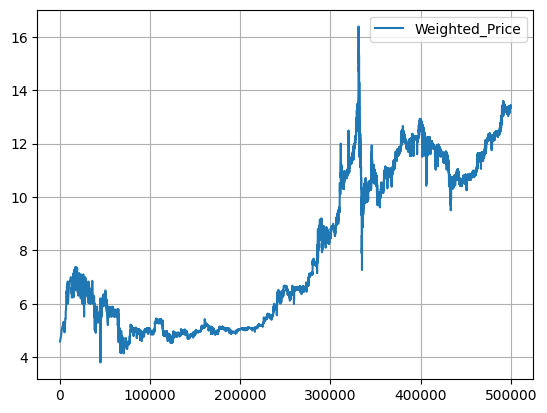

In [22]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()


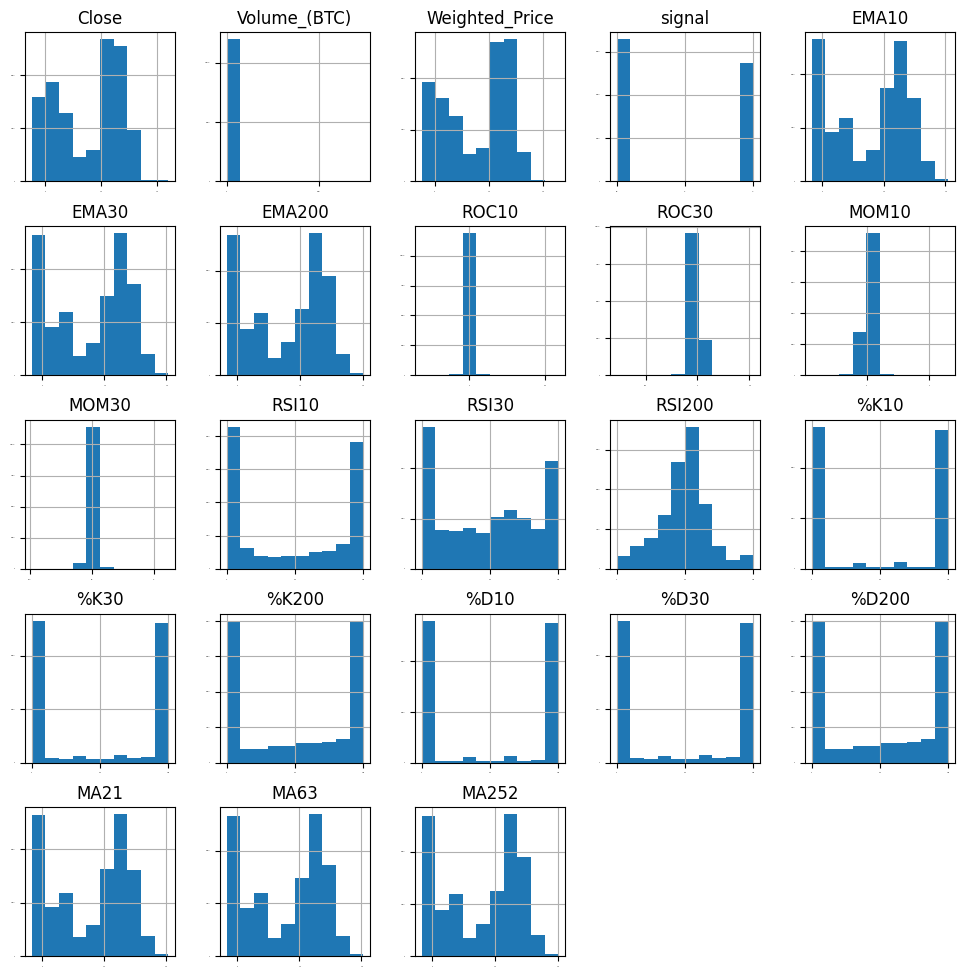

In [23]:
# Histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.show()


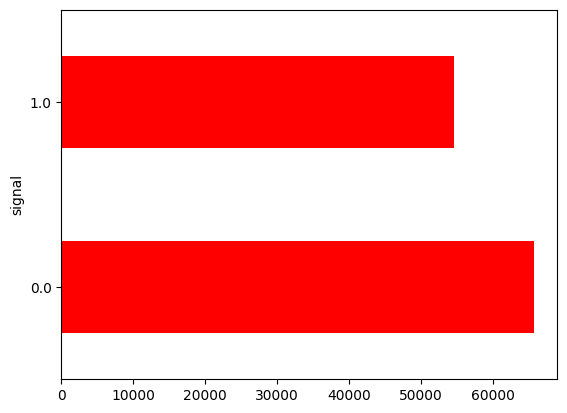

In [24]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

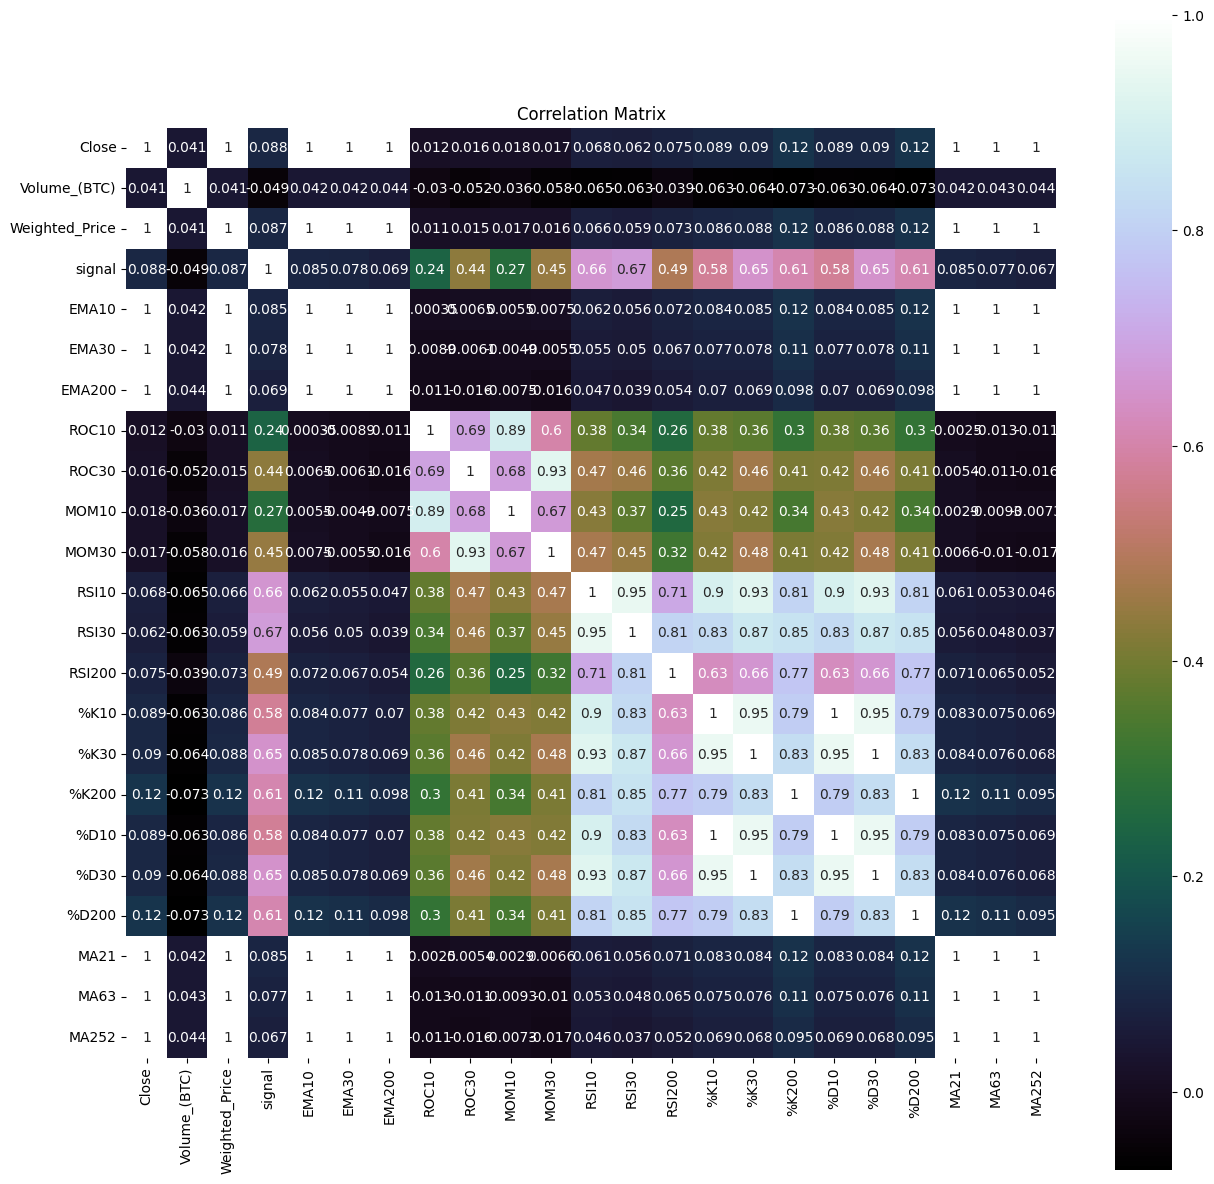

In [25]:
# Correlation
correlation = dataset.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [26]:
# Split out validation dataset for the end

seed = 1
validation_size = 0.2
subset_dataset= dataset.iloc[-100000:]
Y = subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)


<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [27]:
# Test options for classification

num_folds = 10
seed = 7
scoring = 'accuracy'
# scoring = 'precision'
# scoring = 'recall'
# scoring ='neg_log_loss'
# scoring = 'roc_auc'


<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate the following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [28]:
# Spot check the algorithms

models = [
    # Linear models
    ('LR', LogisticRegression(n_jobs=-1)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),

    # # Neural Network model
    # ('NN', MLPClassifier()), # Too slow

    # Ensable Models 
    ('AB', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('RF', RandomForestClassifier(n_jobs=-1)),
]


### K-folds cross validation

In [29]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})")


/home/william/github/will-i-amv-books/ml-and-ds-blueprints-for-finance/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/william/github/will-i-amv-books/ml-and-ds-blueprints-for-finance/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

LR: 0.862512 (0.003844)
LDA: 0.870525 (0.003182)
KNN: 0.903587 (0.001939)
CART: 0.932000 (0.002593)
NB: 0.813987 (0.002943)
AB: 0.865600 (0.003419)
GBM: 0.888525 (0.002821)
RF: 0.939712 (0.002374)


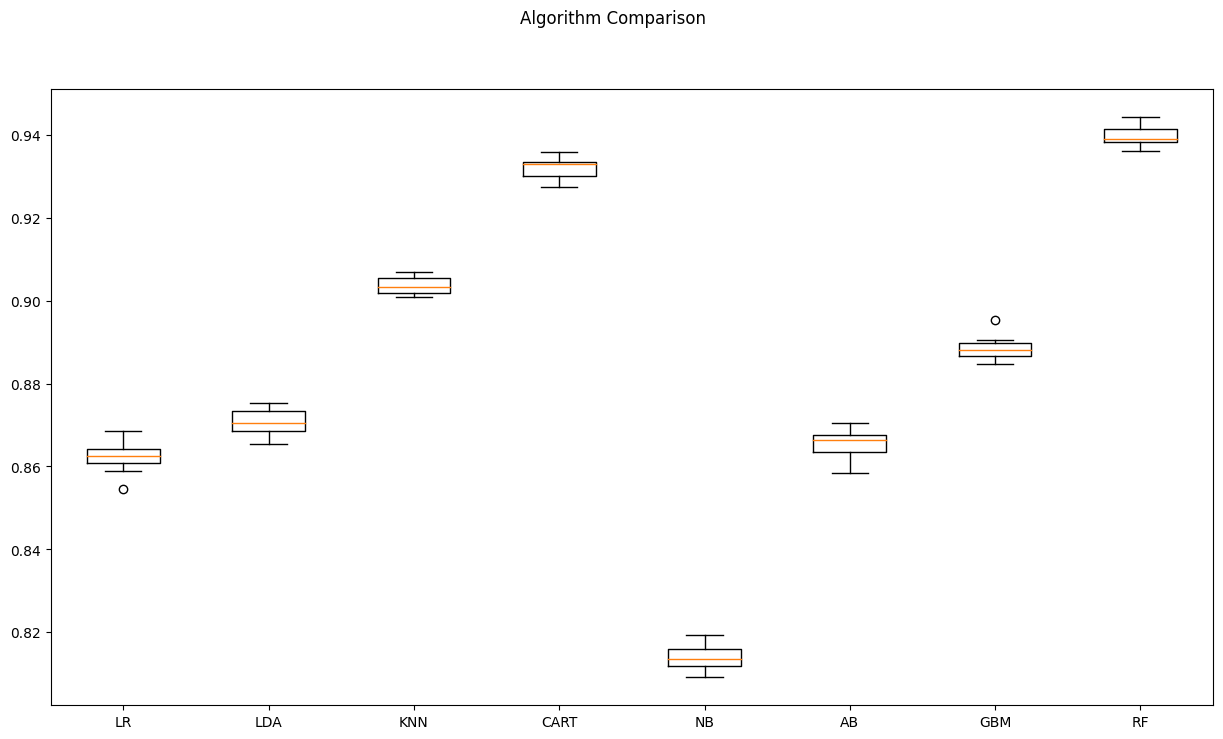

In [31]:
# Compare algorithms

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()


<a id='5'></a>
# 6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [33]:
# Grid Search: Random Forest Classifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth= [5, 10]
criterion = ["gini", "entropy"]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'criterion': criterion}
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print Results
print(f"Best: {grid_result.best_score_:.6f} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print(f"#{rank} {mean:.6f} ({stdev:.6f}) with: {param}")


Best: 0.909075 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.871000 (0.003380) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.872800 (0.002292) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.907863 (0.003047) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.909075 (0.003752) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.867537 (0.003588) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.871300 (0.002673) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.905575 (0.003200) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.906475 (0.003863) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [34]:
grid_result.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}

In [35]:
# Prepare model

model = RandomForestClassifier(
    criterion=grid_result.best_params_['criterion'], 
    n_estimators=grid_result.best_params_['n_estimators'],
    max_depth=grid_result.best_params_['max_depth'],
    n_jobs=-1
) 
model.fit(X_train, Y_train)

# Estimate accuracy on validation set

predictions = model.predict(X_validation)


In [36]:
print(accuracy_score(Y_validation, predictions))



0.9155


In [37]:
print(confusion_matrix(Y_validation, predictions))


[[9729  771]
 [ 919 8581]]


In [38]:
print(classification_report(Y_validation, predictions))


              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     10500
         1.0       0.92      0.90      0.91      9500

    accuracy                           0.92     20000
   macro avg       0.92      0.91      0.92     20000
weighted avg       0.92      0.92      0.92     20000



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

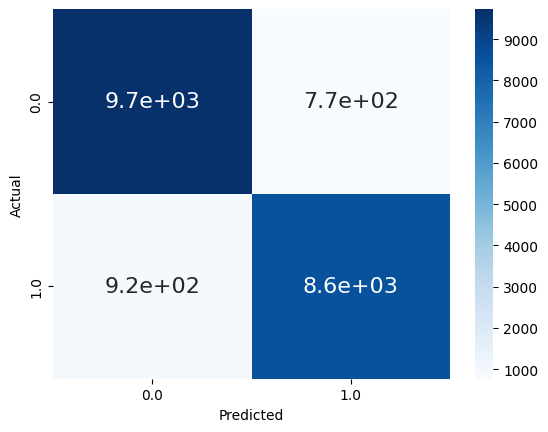

In [39]:
df_cm = pd.DataFrame(
    confusion_matrix(Y_validation, predictions), 
    columns=np.unique(Y_validation), 
    index=np.unique(Y_validation),
)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}) # Font sizes


<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

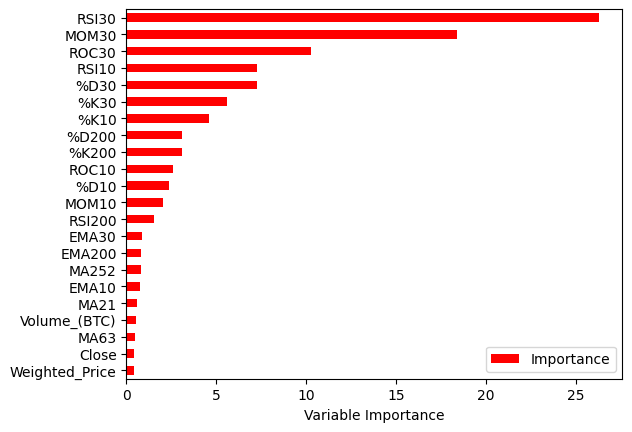

In [40]:
Importance = pd.DataFrame({'Importance': model.feature_importances_ * 100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')


<a id='7'></a>
## 8. Backtesting Results

In [41]:
# Create column for Strategy Returns by multiplying the daily returns by the position 
# that was held at close of business the previous day

backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()


,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
0,333379,1.0,0.0,NaN,NaN,NaN
1,458789,1.0,1.0,-0.076,-0.000,-0.076
2,228505,0.0,0.0,-0.502,-0.502,-0.502
3,443406,1.0,1.0,0.972,0.000,0.000
4,485465,0.0,0.0,0.147,0.147,0.147


<AxesSubplot:>

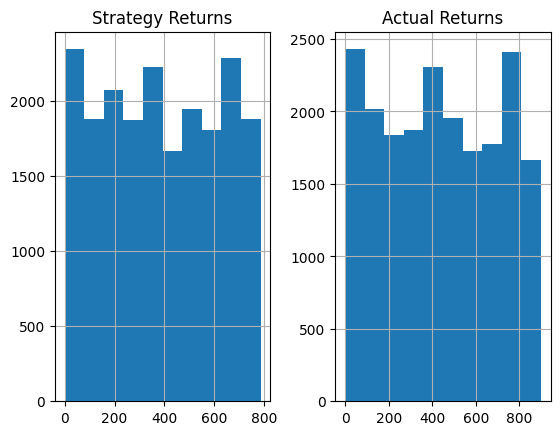

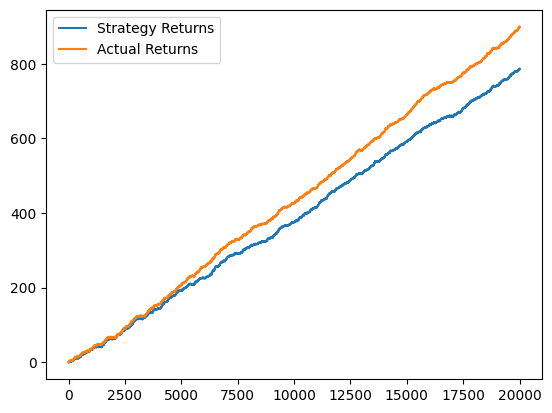

In [42]:
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()


__Conclusion__:

We showed that framing the problem is the first priority and we address it by engi‐
neering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a
trading strategy using historical data to generate results and analyze risk and profita‐
bility before risking any actual capital.
